In [15]:
#imports
import numpy as np
import core as mr
import matplotlib.pyplot as plt
import time

In [2]:
#parameters of the UR5 robot

M01 = [[1, 0, 0, 0], 
       [0, 1, 0, 0], 
       [0, 0, 1, 0.089159], 
       [0, 0, 0, 1]]

M12 = [[0, 0, 1, 0.28], 
       [0, 1, 0, 0.13585], 
       [-1, 0, 0, 0], 
       [0, 0, 0, 1]]

M23 = [[1, 0, 0, 0], 
       [0, 1, 0, -0.1197], 
       [0, 0, 1, 0.395], 
       [0, 0, 0, 1]]

M34 = [[0, 0, 1, 0], 
       [0, 1, 0, 0], 
       [-1, 0, 0, 0.14225], 
       [0, 0, 0, 1]]

M45 = [[1, 0, 0, 0], 
       [0, 1, 0, 0.093], 
       [0, 0, 1, 0], 
       [0, 0, 0, 1]]

M56 = [[1, 0, 0, 0], 
       [0, 1, 0, 0], 
       [0, 0, 1, 0.09465], 
       [0, 0, 0, 1]]

M67 = [[1, 0, 0, 0], 
       [0, 0, 1, 0.0823], 
       [0, -1, 0, 0], 
       [0, 0, 0, 1]]

G1 = np.diag([0.010267495893, 0.010267495893,  0.00666, 3.7, 3.7, 3.7])
G2 = np.diag([0.22689067591, 0.22689067591, 0.0151074, 8.393, 8.393, 8.393])
G3 = np.diag([0.049443313556, 0.049443313556, 0.004095, 2.275, 2.275, 2.275])
G4 = np.diag([0.111172755531, 0.111172755531, 0.21942, 1.219, 1.219, 1.219])
G5 = np.diag([0.111172755531, 0.111172755531, 0.21942, 1.219, 1.219, 1.219])
G6 = np.diag([0.0171364731454, 0.0171364731454, 0.033822, 0.1879, 0.1879, 0.1879])

In [3]:
Glist = [G1, G2, G3, G4, G5, G6]
Mlist = [M01, M12, M23, M34, M45, M56, M67] 

Slist = [[0,         0,         0,         0,        0,        0],
         [0,         1,         1,         1,        0,        1],
         [1,         0,         0,         0,       -1,        0],
         [0, -0.089159, -0.089159, -0.089159, -0.10915, 0.005491],
         [0,         0,         0,         0,  0.81725,        0],
         [0,         0,     0.425,   0.81725,        0,  0.81725]]

In [4]:
#helper functions
def write_csv_line(csv_filename, data):
    with open(csv_filename, 'a') as f:
        data_str = ','.join([str(i) for i in data]) + '\n'
        f.write(data_str)
###

def write_csv_mat(csv_filename, mat):
    for row in mat:
            write_csv_line(csv_filename, row)
###
    
def ModEulerStep(thetalist, dthetalist, ddthetalist, dt):
    """EulerStep from the MR library, but with an additional
    second-order term from acceleration contributing to changes in position.
    """
    return thetalist + (dt * np.array(dthetalist) + 0.5 * dt**2 * np.array(dthetalist) ), \
           dthetalist + dt * np.array(ddthetalist)
###

In [5]:
#component functions for spring force, damping force, and simulation

def SpringForce(Slist, thetalist, Mlist, stiffness, springPos, restLength):
    '''
    - Calculates the "spring force" acting on the end effector
        of the robot, using position of end of spring, position
        of end effector, and spring parameters.
    - takes in:
        -Slist: list of screw axes in space frame 
        -thetalist: list of current joint angles 
        -Mlist: home configurations of each joint rel. to.
            each other
        -stiffness: scalar with spring constant
        -springPos: 3-vector position 
        -restLength: scalar with resting length of spring
    - calls:
        - T = FKinBody(M_endeff, Blist, thetalist)
        - [R,p] = TranstoRp(FKinBody)
        - x_diff = np.linalg.norm(deltap) - restLength
    - returns:
        Ftip, a 6x1 end-effector wrench caused by the spring force
    '''

    # - Find home configuration of end effector
    M_matrices = [np.matrix(M) for M in Mlist]
    M_ee = M_matrices[0] * \
            M_matrices[1] * \
            M_matrices[2] * \
            M_matrices[3] * \
            M_matrices[4] * \
            M_matrices[5] * \
            M_matrices[6]
    
    #     - apply product of exponentials in space frame
    T = mr.FKinSpace(M_ee, Slist, thetalist)
    [R,p] = mr.TransToRp(T)
    
    # - Define transformation to get from EE to spring posn, and apply spring force
    dp = springPos - p
    Fs = stiffness * np.array([0, 0, 0, dp[0], dp[1], dp[2]])
                              
    return Fs

def DampingForce(B, thetad_list):
    '''
    - Make a torque at each joint, equal to B * w
    - takes in:
        - damping constant B
        - thetad_list: an nd-array, where n = # of joints of robot
    - returns:
        - an nd-array of joint torques, where n = # of joints
    '''
    tau_list = -B * np.array(thetad_list)
    return tau_list

In [6]:
#testing: plug in joint angles that give known positions; check that 
#position difference is close to expected values; force is a constant times that
M_matrices = [np.matrix(M) for M in Mlist]
M_ee = M_matrices[0] * \
        M_matrices[1] * \
        M_matrices[2] * \
        M_matrices[3] * \
        M_matrices[4] * \
        M_matrices[5] * \
        M_matrices[6]

robot_posn = [0.1, 0.3, 0.6]
R = np.identity(3)
T = mr.RpToTrans(R, robot_posn)
thetalist0 = [0.504, -0.168, -1.713, 4.131, 0.000, 0.000]
thetalist, success = mr.IKinSpace(Slist, M_ee, T, thetalist0, 0.001, 0.0001)
thetalist = thetalist.round(4).tolist()

# print(M_ee) #looks as expected in CoppeliaSim
# print(thetalist) #[0.8966, -0.0886, -1.5636, 3.2229, -1.5708, 0.6742]
# print(success)

spring_posn = [0.2, 0.4, 0.7]
stiffness = 1
restLength = 0
expected_wrench = [0, 0, 0, 0.1, 0.1, 0.1]

#check that spring force matches expected value
wrench = SpringForce(Slist, thetalist, Mlist, stiffness, spring_posn, restLength)
assert np.allclose(expected_wrench, wrench, rtol = 1E-4, atol = 1E-4)

thetalist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
damping = 0.2
assert np.allclose(DampingForce(damping, thetalist), [-0.02, -0.04, -0.06, -0.08, -0.10, -0.12])

In [19]:
def Puppet(damping, stiffness, restLength, springPos,\
          tf, dt, \
          g, Mlist, Glist, Slist, \
          thetalist0, thetadlist0): 
    '''
    - takes in
        - damping stiffness restLength
        - g, Mlist, Glist, Slist (g may be 0 in one sim)
        - thetalist0, dthetalist0
    - calculates
        - end effector wrench Ftip
        - applied joint torques taulist
    - calls 
        - mr.ForwardDynamics(thetalist,dthetalist,taulist,
            g,Ftip,Mlist,Glist,Slist)
        - ModEulerStep(thetalist,dthetalist,ddthetalist,dt)
        - SpringForce()
        - DampingForce()
    - returns: a N x n matrix of joint values, N = # of timesteps,
        n = number of joints
    '''
    
    thetalist = thetalist0[:]
    thetadlist = thetadlist0[:]    
    t_array = np.arange(0, tf, dt)
    traj_array = np.zeros([len(t_array), len(thetalist)]) #N timesteps, n angles
        
    print(f"Shape of Time array: {t_array.shape}")
    print(f"Shape of Traj array: {traj_array.shape}")
    
    
    to = time.time()
        
    for i, t in enumerate(t_array):
                
        #calculate forces
        taulist = DampingForce(damping, thetalist) 
        
        # - Call ForwardDynamics() with starting values of thetad,
        #     thetadd, theta
        Ftip = SpringForce(Slist, thetalist, Mlist, stiffness, springPos, restLength)
        thetaddlist = mr.ForwardDynamics(thetalist, thetadlist, taulist, \
                                            g, Ftip, Mlist, Glist, Slist)
        
        # - use numerical integration to find theta, thetad at next timestep
        thetalist_new, thetadlist_new = ModEulerStep(thetalist, thetadlist, thetaddlist, dt)
        
        # - store value of theta at next timestep in an array; reset theta and thetad       
        traj_array[i,:] = thetalist_new
        thetalist = thetalist_new
        thetadlist = thetadlist_new
        
    #may want to change names of inputs to exactly match the asst later
    return traj_array

###
#testing
damping = 0
stiffness = 0
restlength = 0
tf = 5
dt = 0.01

g = 9.81 * np.array([0, 0, -1])
thetalist0 = [0,0,0,0,0,0]
dthetalist0 = [0,0,0,0,0,0]
springPosn = [0, 1, 2]  

In [20]:
t_array = np.arange(0, tf, dt)

realtime0 = time.time()
traj_array = Puppet(damping, stiffness, restLength, springPosn, tf, dt, g, Mlist, Glist, Slist, thetalist0, dthetalist0)
realtimef = time.time()
print(f"Elapsed: {realtimef - realtime0}")

Shape of Time array: (500,)
Shape of Traj array: (500, 6)
Elapsed: 58.337610960006714


In [12]:
print(traj_array)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.58523527e-03 -2.88804969e-03  3.02814426e-04
  -1.88814818e-22 -9.64832902e-19]
 [-6.60431876e-07  7.75570580e-03 -8.66414908e-03  9.08221789e-04
  -6.60431876e-07  2.21489399e-07]
 ...
 [ 2.23875792e-01 -6.28424548e-01 -1.09839179e+01  1.18963646e+01
   2.06621188e-01 -2.85463917e-01]
 [ 2.18457024e-01 -6.64259737e-01 -1.10486060e+01  1.19996701e+01
   2.01476196e-01 -2.88605846e-01]
 [ 2.13423596e-01 -6.94168614e-01 -1.11191438e+01  1.21027566e+01
   1.96705781e-01 -2.91584958e-01]]


<Figure size 640x480 with 0 Axes>

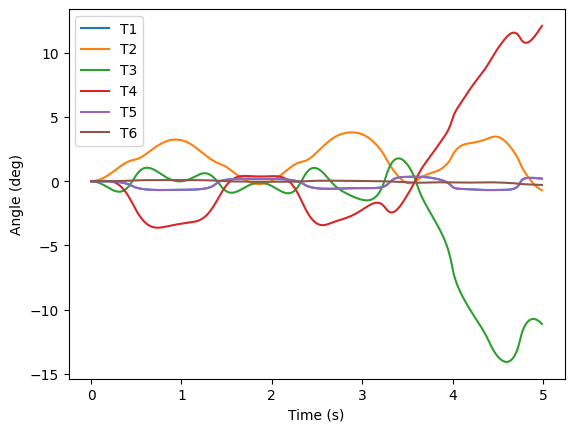

In [24]:
#validation: check tracking trajectory of one angle to make sure it's reasonable
plt.clf()
plt.figure()
plt.plot(t_array, traj_array)
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.legend(["T1","T2","T3", "T4", "T5", "T6"])
plt.show()

In [26]:
write_csv_mat("HW3_traj.csv",traj_array)
#Post-Puppet:
#     - Write the theta_array to a CSV file
#     - import the CSV file into CoppeliaSim
#     - adjust time multiplier so it takes 5s real time to play file.
#         record results for time multiplier.